
# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

# image capture 

In [2]:
import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()
print(img_name)

Escape hit, closing...


NameError: name 'img_name' is not defined

# Analyzing

In [3]:
train_dir = 'C:/Users/KIIT/train/'
test_dir = 'C:/Users/KIIT/test/'

row = 48
col = 48
classes = len(os.listdir('C:/Users/KIIT/train/'))

In [4]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
angry folder contains		 3995 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


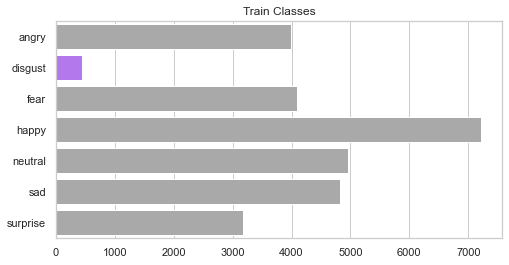

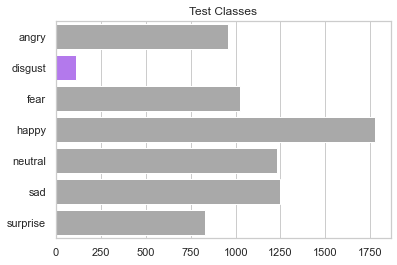

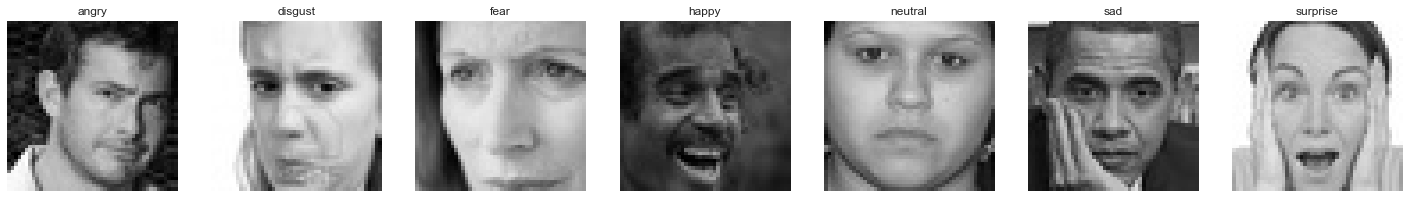

In [5]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

# Preprocessing

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)


training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Model

In [7]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [8]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

C:\Users\KIIT\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
plot_model(fernet, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Checkpoint

In [9]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [10]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=48,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
          
                  validation_steps=validation_steps)

Epoch 1/48
448/448 [==============================] - ETA: 0s - loss: 4.2465 - accuracy: 0.2814
Epoch 1: val_loss improved from inf to 5.17656, saving model to ferNet.h5
448/448 [==============================] - 390s 865ms/step - loss: 4.2465 - accuracy: 0.2814 - val_loss: 5.1766 - val_accuracy: 0.2174 - lr: 1.0000e-04
Epoch 2/48
448/448 [==============================] - ETA: 0s - loss: 3.4568 - accuracy: 0.3462
Epoch 2: val_loss improved from 5.17656 to 3.09883, saving model to ferNet.h5
448/448 [==============================] - 391s 873ms/step - loss: 3.4568 - accuracy: 0.3462 - val_loss: 3.0988 - val_accuracy: 0.4021 - lr: 1.0000e-04
Epoch 3/48
448/448 [==============================] - ETA: 0s - loss: 2.9190 - accuracy: 0.3864
Epoch 3: val_loss improved from 3.09883 to 2.55841, saving model to ferNet.h5
448/448 [==============================] - 380s 848ms/step - loss: 2.9190 - accuracy: 0.3864 - val_loss: 2.5584 - val_accuracy: 0.4562 - lr: 1.0000e-04
Epoch 4/48
448/448 [======

Epoch 27/48
448/448 [==============================] - ETA: 0s - loss: 0.9014 - accuracy: 0.7022
Epoch 27: val_loss did not improve from 1.08969
448/448 [==============================] - 364s 813ms/step - loss: 0.9014 - accuracy: 0.7022 - val_loss: 1.1048 - val_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 28/48
448/448 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.7078
Epoch 28: val_loss improved from 1.08969 to 1.08428, saving model to ferNet.h5
448/448 [==============================] - 371s 828ms/step - loss: 0.8827 - accuracy: 0.7078 - val_loss: 1.0843 - val_accuracy: 0.6424 - lr: 1.0000e-04
Epoch 29/48
448/448 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.7129
Epoch 29: val_loss improved from 1.08428 to 1.08020, saving model to ferNet.h5
448/448 [==============================] - 381s 851ms/step - loss: 0.8676 - accuracy: 0.7129 - val_loss: 1.0802 - val_accuracy: 0.6479 - lr: 1.0000e-04
Epoch 30/48
448/448 [==========================

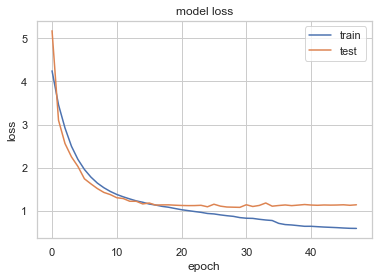

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

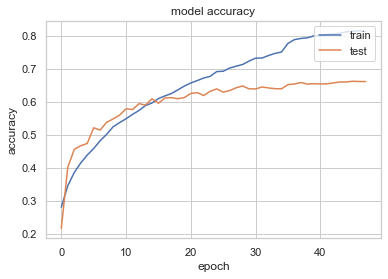

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 16s 144ms/step - loss: 1.1396 - accuracy: 0.6608
final train accuracy = 89.79 , validation accuracy = 66.08


# Result

449/449 [==============================] - 67s 148ms/step
Confusion Matrix
[[ 518   54  539 1000  745  671  468]
 [  51   11   57  107   78   82   50]
 [ 551   60  581 1081  713  666  445]
 [1031  106  900 1877 1245 1283  773]
 [ 716   69  660 1257  906  815  542]
 [ 605   56  661 1279  910  799  520]
 [ 410   40  422  793  615  554  337]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3995
     disgust       0.03      0.03      0.03       436
        fear       0.15      0.14      0.15      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.16      0.17      0.16      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



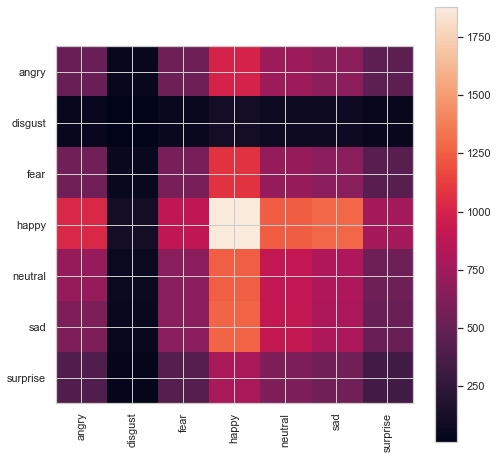

In [14]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [15]:
fernet.save("2130094")


INFO:tensorflow:Assets written to: 2130094\assets


INFO:tensorflow:Assets written to: 2130094\assets


In [16]:
import tensorflow.keras.models

In [17]:
models = tensorflow.keras.models.load_model('2130094')

In [18]:
models

# Recommending Music And Movies


In [55]:
mood_music = pd.read_csv("C:/Users/KIIT/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic
...,...,...,...
681,windcatcher,Leo Nocta,Calm
682,yellow is the color of her eyes,Soccer Mommy,Sad
683,you broke me first,Tate McRae,Sad
684,you were good to me,Jeremy Zucker,Sad


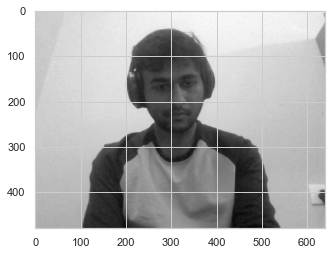

In [56]:
image = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [57]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=models.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 157ms/step


3

In [58]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)


,index,name,artist,mood
0,653,Wonderwall,Oasis,Happy
1,502,Spirit In The Sky,Norman Greenbaum,Happy
2,612,Wait For Me,Steve Brian,Happy
3,617,War,Kensington,Happy
4,530,Take Everything,Gareth Emery,Happy


In [59]:
movie=pd.read_csv("movies.csv")
mood_movie=movie[['title','genres']]
movie



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [60]:
filter1=mood_movie["genres"]
j=0
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_movie["genres"]
    for i in filter1:
        l1=list(i.split("|"))
        if"Comedy" in l1:
            print(mood_movie.iloc[j])
        j+=1
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_movie["genres"]
    for i in filter1:
        l1=list(i.split("|"))
        if "Adventure" and "Mystery" in l1:
            print(mood_movie.iloc[j])
        j+=1
if(result[0]==5):
       #for Sad
     filter1=mood_movie["genres"]
     for i in filter1:
        l1=list(i.split("|"))
        if "Action" and "Sci-Fi" in l1:
            print(mood_movie.iloc[j])
        j+=1
if(result[0]==6):
     #for surprise
     filter1=mood_movie["genres"]
     for i in filter1:
        l1=list(i.split("|"))
        if "Drama" and "Documentry" in l1:
            print(mood_movie.iloc[j])
        j+=1

title                          Copycat (1995)
genres    Crime|Drama|Horror|Mystery|Thriller
Name: 21, dtype: object
title     City of Lost Children, The (Cité des enfants p...
genres               Adventure|Drama|Fantasy|Mystery|Sci-Fi
Name: 28, dtype: object
title     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
genres                      Mystery|Sci-Fi|Thriller
Name: 31, dtype: object
title     Seven (a.k.a. Se7en) (1995)
genres               Mystery|Thriller
Name: 43, dtype: object
title     Usual Suspects, The (1995)
genres        Crime|Mystery|Thriller
Name: 46, dtype: object
title        Unforgettable (1996)
genres    Mystery|Sci-Fi|Thriller
Name: 91, dtype: object
title     Before and After (1996)
genres              Drama|Mystery
Name: 100, dtype: object
title     Chungking Express (Chung Hing sam lam) (1994)
genres                            Drama|Mystery|Romance
Name: 107, dtype: object
title         Clockers (1995)
genres    Crime|Drama|Mystery
Name: 132, dtype: object
title  

Name: 1286, dtype: object
title                    Scream 2 (1997)
genres    Comedy|Horror|Mystery|Thriller
Name: 1288, dtype: object
title                          Palmetto (1998)
genres    Crime|Drama|Mystery|Romance|Thriller
Name: 1321, dtype: object
title                    Suicide Kings (1997)
genres    Comedy|Crime|Drama|Mystery|Thriller
Name: 1330, dtype: object
title               Wild Things (1998)
genres    Crime|Drama|Mystery|Thriller
Name: 1333, dtype: object
title     Spanish Prisoner, The (1997)
genres    Crime|Drama|Mystery|Thriller
Name: 1348, dtype: object
title          Zero Effect (1998)
genres    Comedy|Mystery|Thriller
Name: 1356, dtype: object
title            Insomnia (1997)
genres    Drama|Mystery|Thriller
Name: 1379, dtype: object
title     X-Files: Fight the Future, The (1998)
genres     Action|Crime|Mystery|Sci-Fi|Thriller
Name: 1391, dtype: object
title     Picnic at Hanging Rock (1975)
genres                    Drama|Mystery
Name: 1395, dtype: object
title 

Name: 2618, dtype: object
title          No Way Out (1987)
genres    Drama|Mystery|Thriller
Name: 2620, dtype: object
title            American Psycho (2000)
genres    Crime|Horror|Mystery|Thriller
Name: 2641, dtype: object
title     Jennifer 8 (1992)
genres     Mystery|Thriller
Name: 2659, dtype: object
title                    Angel Heart (1987)
genres    Film-Noir|Horror|Mystery|Thriller
Name: 2768, dtype: object
title     Conversation, The (1974)
genres               Drama|Mystery
Name: 2789, dtype: object
title     Blow-Up (Blowup) (1966)
genres              Drama|Mystery
Name: 2831, dtype: object
title     What Lies Beneath (2000)
genres        Drama|Horror|Mystery
Name: 2840, dtype: object
title     Anatomy of a Murder (1959)
genres                 Drama|Mystery
Name: 2842, dtype: object
title     The Spiral Staircase (1945)
genres        Horror|Mystery|Thriller
Name: 2879, dtype: object
title     Faraway, So Close (In weiter Ferne, so nah!) (...
genres                        Dr

Name: 4128, dtype: object
title      Black Christmas (1974)
genres    Horror|Mystery|Thriller
Name: 4155, dtype: object
title     American Friend, The (Amerikanische Freund, De...
genres                         Crime|Drama|Mystery|Thriller
Name: 4178, dtype: object
title             Missing (1982)
genres    Drama|Mystery|Thriller
Name: 4211, dtype: object
title              Tenebre (1982)
genres    Horror|Mystery|Thriller
Name: 4221, dtype: object
title     Spider (2002)
genres    Drama|Mystery
Name: 4250, dtype: object
title     Irreversible (Irréversible) (2002)
genres          Crime|Drama|Mystery|Thriller
Name: 4258, dtype: object
title      Equus (1977)
genres    Drama|Mystery
Name: 4270, dtype: object
title         Ringu (Ring) (1998)
genres    Horror|Mystery|Thriller
Name: 4276, dtype: object
title            In a Lonely Place (1950)
genres    Drama|Film-Noir|Mystery|Romance
Name: 4294, dtype: object
title                          Holes (2003)
genres    Adventure|Children|Comedy|

Name: 5397, dtype: object
title     Lady from Shanghai, The (1947)
genres           Drama|Film-Noir|Mystery
Name: 5433, dtype: object
title       Confidential Report (1955)
genres    Crime|Drama|Mystery|Thriller
Name: 5442, dtype: object
title                 Duel (1971)
genres    Action|Mystery|Thriller
Name: 5478, dtype: object
title     Smiley's People (1982)
genres             Drama|Mystery
Name: 5509, dtype: object
title                                Cloak & Dagger (1984)
genres    Action|Adventure|Children|Crime|Mystery|Thriller
Name: 5516, dtype: object
title     Quiet Earth, The (1985)
genres       Drama|Mystery|Sci-Fi
Name: 5525, dtype: object
title                 Bourne Identity, The (1988)
genres    Action|Adventure|Drama|Mystery|Thriller
Name: 5539, dtype: object
title     Alice (Neco z Alenky) (1988)
genres       Animation|Fantasy|Mystery
Name: 5543, dtype: object
title                                 It (1990)
genres    Drama|Fantasy|Horror|Mystery|Thriller
Name: 5551, 

Name: 7427, dtype: object
title                Devil (2010)
genres    Horror|Mystery|Thriller
Name: 7430, dtype: object
title          Catfish (2010)
genres    Documentary|Mystery
Name: 7433, dtype: object
title                                         Rubber (2010)
genres    Action|Adventure|Comedy|Crime|Drama|Film-Noir|...
Name: 7441, dtype: object
title     Saw VII 3D - The Final Chapter (2010)
genres                  Horror|Mystery|Thriller
Name: 7452, dtype: object
title     All Good Things (2010)
genres    Drama|Mystery|Thriller
Name: 7482, dtype: object
title             Unknown (2011)
genres    Drama|Mystery|Thriller
Name: 7528, dtype: object
title     Scooby-Doo! Curse of the Lake Monster (2010)
genres               Adventure|Children|Comedy|Mystery
Name: 7551, dtype: object
title              Red Riding Hood (2011)
genres    Fantasy|Horror|Mystery|Thriller
Name: 7558, dtype: object
title                       Source Code (2011)
genres    Action|Drama|Mystery|Sci-Fi|Thriller
Na

Name: 8995, dtype: object
title     Secret in Their Eyes (2015)
genres            Crime|Drama|Mystery
Name: 9019, dtype: object
title       The Lost Room (2006)
genres    Action|Fantasy|Mystery
Name: 9026, dtype: object
title        Every Secret Thing (2014)
genres    Crime|Drama|Mystery|Thriller
Name: 9028, dtype: object
title         The Editor (2015)
genres    Comedy|Horror|Mystery
Name: 9068, dtype: object
title           Narcopolis (2014)
genres    Mystery|Sci-Fi|Thriller
Name: 9085, dtype: object
title     The Great Hypnotist (2014)
genres        Drama|Mystery|Thriller
Name: 9092, dtype: object
title     Extraordinary Tales (2015)
genres      Animation|Horror|Mystery
Name: 9112, dtype: object
title     The Adventures of Sherlock Holmes and Dr. Wats...
genres                                        Crime|Mystery
Name: 9124, dtype: object
title                Solace (2015)
genres    Fantasy|Mystery|Thriller
Name: 9132, dtype: object
title     The Adventures of Sherlock Holmes and Do

# chatbot

In [23]:
data={"intents": [
        
        {"tag": "success",
             "patterns": ["hey I completed my project", "I got selected", "I got promoted" ],
         "responses": ["Congrats!you deserved it","Party time!! so happy for you","So proud of you"],
         "context": [""]
        },
        {"tag": "disgusted",
             "patterns": ["he spits while eating", "she is creepy", "he is always making me uncomfortable" ],
         "responses": ["you can talk to them about this","you are too good for h","You don't have to be around that person"],
         "context": [""]
        },
        {"tag": "angry",
             "patterns": ["this is such a waste of time", "I'm so done now", "I am so angry about it" ],
         "responses": ["Calm down you'll be fine","It's okay I am always here","Hey champ don't waste yourself"],
         "context": [""]
        },
        {"tag": "travel",
             "patterns": ["I wish to travel", "I want to explore myself", "I want to find as new hobby" ],
         "responses": ["Sure dude that's awesome","good to see you like this","That's a rocking idea"],
         "context": [""]
        },
        {"tag": "greet",
             "patterns": ["Hi", "Hey", "How are you?" ],
         "responses": ["Hi good to see you","hey dude what's up?","hey I'm great how about you?"],
         "context": [""]
        },
        {"tag": "life",
             "patterns": ["what is life?", "when will I succeed?", "Why do I fail?" ],
         "responses": ["Good things take time","It's okay, it's just a bad phase","come on you will be good"],
         "context": [""]
        },
        {"tag": "music",
        "patterns": ["what's your favorite song?", "who's your favorite artist?", "do you like jazz?" ],
        "responses": ["I like all kinds of music", "I'm not really into music, sorry", "I love classical music"],
        "context": [""]
        },
        {"tag": "movies",
        "patterns": ["what's your favorite movie?", "have you seen the latest Marvel movie?", "what's the best action movie?" ],
        "responses": ["I'm a chatbot, so I don't really watch movies", "I haven't watched any good movies lately", "I love horror movies"],
        "context": [""]
        },
        {"tag": "books",
        "patterns": ["what's your favorite book?", "have you read the latest Stephen King novel?", "what's the best self-help book?" ],
        "responses": ["I don't read books, sorry", "I haven't read any good books lately", "I love mystery novels"],
        "context": [""]
        },
        {"tag": "food",
        "patterns": ["what's your favorite cuisine?", "have you tried Indian food?", "what's the best restaurant in town?" ],
        "responses": ["I'm a chatbot, so I don't really eat food", "I haven't tried any new restaurants lately", "I love Italian food"],
        "context": [""]
        },
        {"tag": "sports",
        "patterns": ["what's your favorite sport?", "have you watched the latest soccer game?", "what's the best sports team?" ],
        "responses": ["I'm a chatbot, so I don't really watch sports", "I haven't watched any good games lately", "I love basketball"],
        "context": [""]
        },
        {"tag": "technology",
        "patterns": ["what's your favorite tech gadget?", "have you tried the latest iPhone?", "what's the best laptop for gaming?" ],
        "responses": ["I'm a chatbot, so I don't really use technology", "I haven't tried any new gadgets lately", "I love Apple products"],
        "context": [""]
        },
        {"tag": "animals",
        "patterns": ["what's your favorite animal?", "have you seen a panda before?", "what's the best pet for kids?" ],
        "responses": ["I'm a chatbot, so I don't really have a favorite animal", "I haven't seen any interesting animals lately", "I love cats"],
        "context": [""]
        },
        {"tag": "politics",
        "patterns": ["what's your political view?", "have you been following the latest election?", "who's the best politician?" ],
        "responses": ["I don't have a political view, sorry", "I haven't been following politics lately", "I don't have an opinion on politicians"],
        "context": [""]
        },
        {"tag": "nature",
        "patterns": ["what's your favorite outdoor activity?", "what's the best place to hike?" ],
        "responses": ["Being in sunshine and out is one's best part of life", "I love hiking in the mountains"],
        "context": [""]
        },
        {
        "tag": "love",
        "patterns": ["I'm in love","How do I know if I'm in love?","I can't stop thinking about them"],
        "responses": ["Love is a beautiful feeling","It sounds like you have strong feelings for them","Love is all about taking a leap of faith"],
        "context": [""]
        },
        {
        "tag": "breakup",
        "patterns": ["I just went through a breakup","How do I get over my ex?","I miss them so much"],
        "responses": ["I'm sorry to hear that","Breakups are tough but you will get through this","Take some time for yourself"],
        "context": [""]
        },
        {
        "tag": "anxiety",
        "patterns": ["I'm feeling anxious","What do I do when I have an anxiety attack?","How do I cope with anxiety?"],
        "responses": ["Take some deep breaths","Try to focus on the present moment","It's okay to ask for help"],
        "context": [""]
        },
        {
        "tag": "depression",
        "patterns": ["I'm feeling depressed","How do I deal with depression?","I don't enjoy anything anymore"],
        "responses": ["It's okay to not be okay","Depression is a common issue, but it can be treated","Have you considered seeking professional help?"],
        "context": [""]
        },
        {
        "tag": "motivation",
        "patterns": ["I need motivation","How do I stay motivated?","I'm feeling demotivated"],
        "responses": ["Think about why you started in the first place","Take small steps towards your goal","You got this!"],
        "context": [""]
        },
        {
        "tag": "stress",
        "patterns": ["I'm feeling stressed","How do I manage stress?","I can't handle the pressure"],
        "responses": ["Take a break and relax","Try some stress-relieving activities like yoga or meditation","Don't hesitate to ask for help"],
        "context": [""]
        },
        {
        "tag": "self-care",
        "patterns": ["I need to practice self-care","How do I take care of myself?","I'm neglecting my needs"],
        "responses": ["Self-care is important, make sure to prioritize it","Take some time for yourself and do something you enjoy","Remember that you deserve to take care of yourself"],
        "context": [""]
        },
        {"tag": "relationships",
        "patterns": ["How do I improve my relationship?","I'm having issues with my partner","What makes a good relationship?"],
        "responses": ["Communication is key in any relationship","Try to understand each other's perspectives","Remember to respect each other"],
        "context": [""]
        }   
        ]
}


# IMPORTING LIBRARY

In [24]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# PREPROCESSING 

In [25]:
training_sentences = []
training_labels = []
labels = []
responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])   
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)


In [26]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [27]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [28]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(16, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 23)                391       
                                                                 
Total params: 16,935
Trainable params: 16,935
Non-trainable params: 0
__________________________________________________

In [31]:
epochs = 200
history = model1.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Epoch 1/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 3/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 4/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 5/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 6/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 7/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 8/200
3/3 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 10/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 11/200
3/3 [===========

3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 168/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 169/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 175/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 177/200
3/3 [=====

In [32]:
train_loss1, train_accu1 = model1.evaluate(training_set)
test_loss1, test_accu1 = model1.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu1*100, test_accu1*100))

NameError: name 'training_set' is not defined

In [33]:
# to save the trained model
model1.save("chat_model")

import pickle

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model\assets


In [34]:
print(data)

{'intents': [{'tag': 'success', 'patterns': ['hey I completed my project', 'I got selected', 'I got promoted'], 'responses': ['Congrats!you deserved it', 'Party time!! so happy for you', 'So proud of you'], 'context': ['']}, {'tag': 'disgusted', 'patterns': ['he spits while eating', 'she is creepy', 'he is always making me uncomfortable'], 'responses': ['you can talk to them about this', 'you are too good for h', "You don't have to be around that person"], 'context': ['']}, {'tag': 'angry', 'patterns': ['this is such a waste of time', "I'm so done now", 'I am so angry about it'], 'responses': ["Calm down you'll be fine", "It's okay I am always here", "Hey champ don't waste yourself"], 'context': ['']}, {'tag': 'travel', 'patterns': ['I wish to travel', 'I want to explore myself', 'I want to find as new hobby'], 'responses': ["Sure dude that's awesome", 'good to see you like this', "That's a rocking idea"], 'context': ['']}, {'tag': 'greet', 'patterns': ['Hi', 'Hey', 'How are you?'], 'r

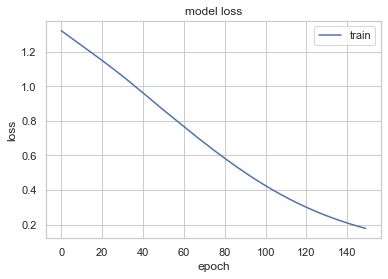

In [14]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

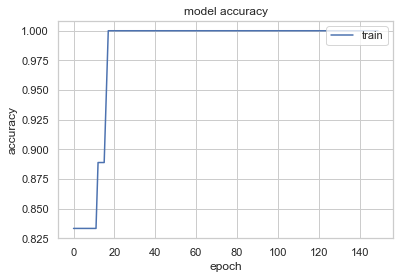

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')